In [ ]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
import pickle


### This tutorial injects a signal into a real dataset

You will need to following additional files;
'spec_template.pkl' which contains a template atmospheric model.

https://tcdud-my.sharepoint.com/:u:/g/personal/gibsonne_tcd_ie/EVKa8Fim5P9Fk_L9eCU86DYBanUtccPoHm27qS1wyhyTIg?e=JPGhm8

And 'hr_data2_v2.pkl', which contains some data, and 'hr5_full_transit.npy', which contains a transit model.

https://tcdud-my.sharepoint.com/:u:/g/personal/gibsonne_tcd_ie/EaRvohlXacdFsNNKYKbowOMBmAJpFVH-ET8oxwQn5oAmUA?e=IR5z9J

https://tcdud-my.sharepoint.com/:u:/g/personal/gibsonne_tcd_ie/EXb78c56FV1OnC6sS46REkUBMdL931Rn8_fMRFbus8GcDA?e=nspY5P

You will also need the SysRem module installed. To do this, unpack the tar.gz/tgz file and place it (ie the folder called SysRem) in the current directory, or on your PYTHONPATH.

https://tcdud-my.sharepoint.com/:u:/g/personal/gibsonne_tcd_ie/EdUev-jF2NdNtq1keBBgLJsBEIsyvw7Nz7Bpp9nsv6-W2Q?e=BKU89n





<IPython.core.display.Javascript object>


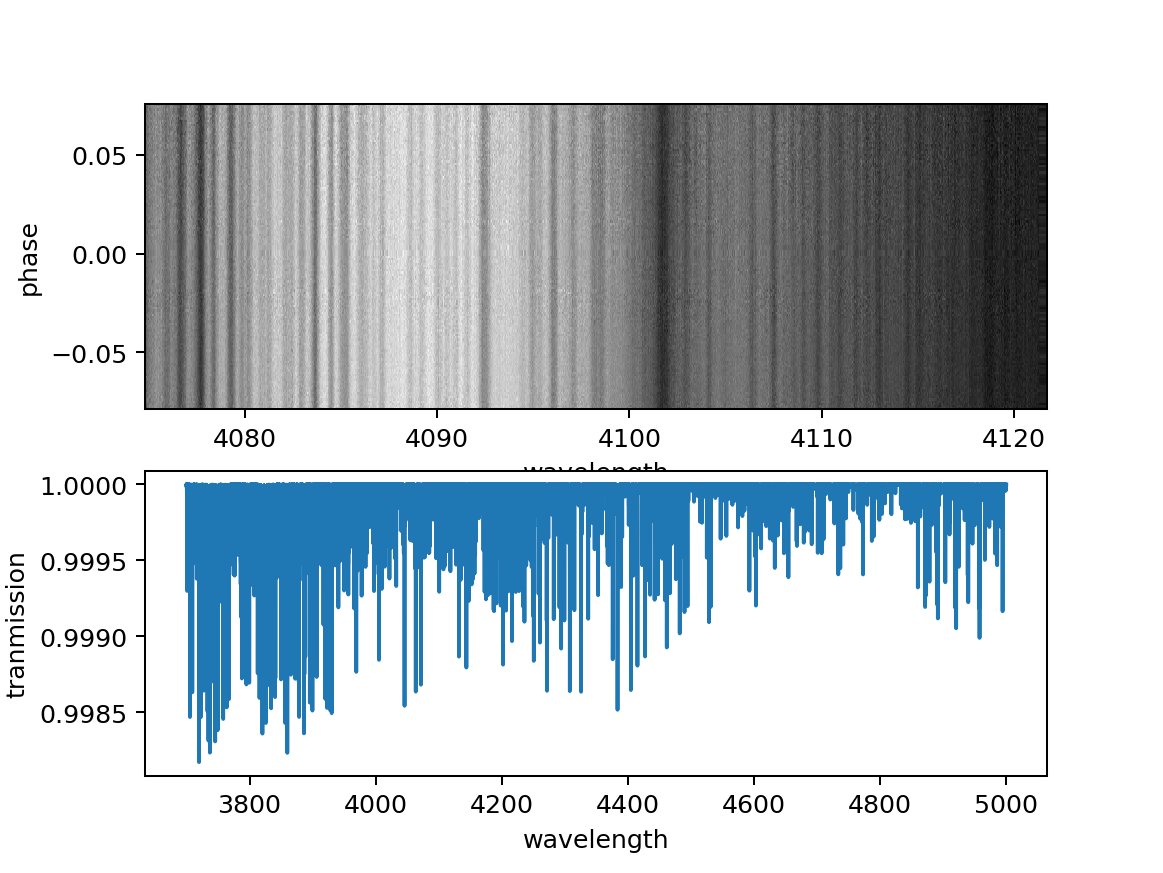

<IPython.core.display.Javascript object>


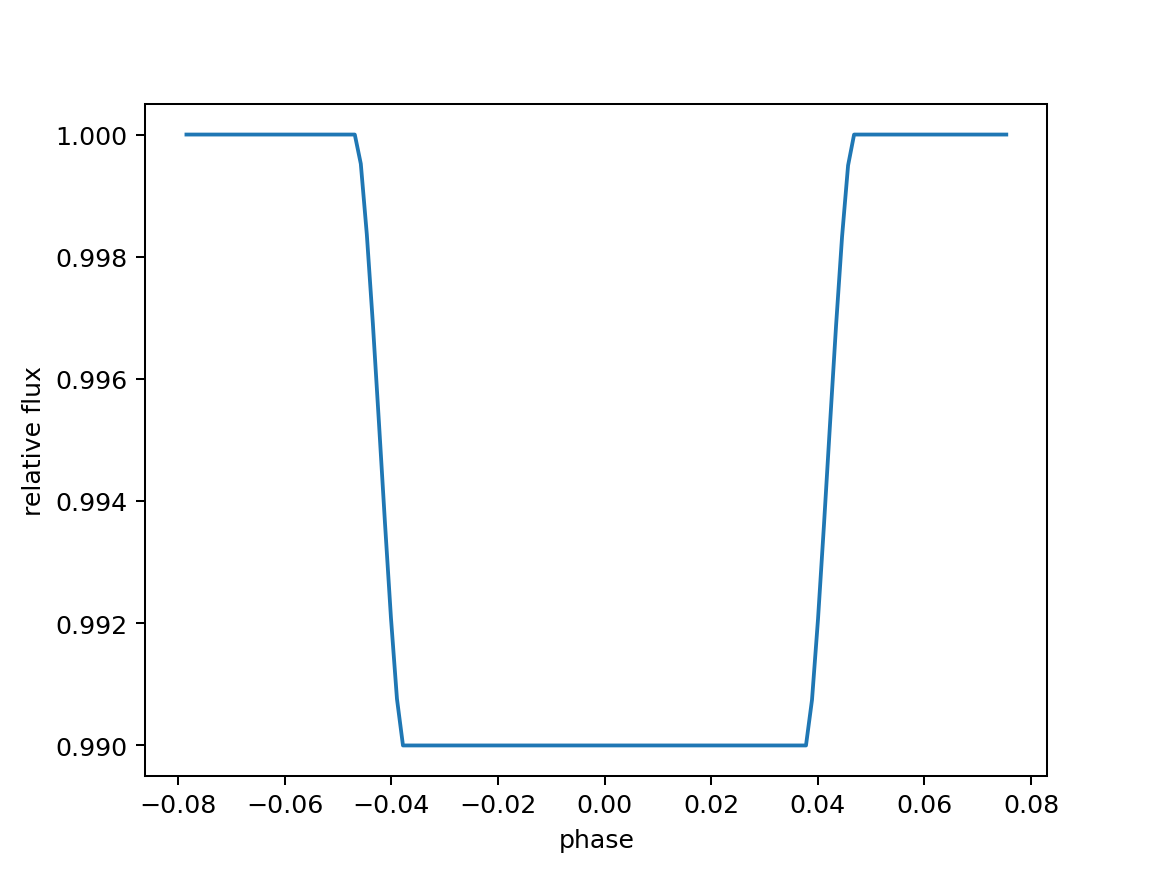

Text(0, 0.5, 'relative flux')

In [2]:

#get spectral template - in this case an iron atmosphere for WASP-121b
d = pickle.load(open('spec_template.pkl','rb'),encoding='latin1')
wl_temp,template = d['w_temp'],d['temp']

#get the dataset
d = pickle.load(open('hr_data2_v2.pkl','rb'))
ph,wl,spec,spec_err,vel = d['phase'],d['wl'],d['spec'],d['spec_err'],d['pvel']

#We will simulate a typical planetary transit observation
#First define the velocity information
Period = 1. #days - orbital period of the planet
Kp = 200 #km/s #velocity amplitude of the planets orbit

vp = Kp*np.sin(ph*2.*np.pi) # planet's velocity for full orbit

#we also need to get a transit function
# (you don't need to worry about the details here for now)
RpRs = 0.1 #planet to star flux ratio
b = 0.1 #impact parameter
aRs = 3.8 #system scale a/Rs (semi-major axis in units of Rstar)
c1,c2 = 0.0,0.0 # limb darkening parameters
tpar = [0,Period,aRs,RpRs,b,c1,c2,1,0] #define transit paramters
tdur = Period / np.pi * np.arcsin(np.sqrt( 1./aRs**2 + RpRs**2 / aRs*2 - (b/aRs)**2)) #get transit duration

#compute the transit - this requires installed software, so will save for now
# import MyFuncs as MF
# flux = MF.Transit_aRs(tpar,ph*Period) 
# np.save('hr5_full_transit.npy',flux)
tmodel = np.load('hr5_full_transit.npy')

#plot the stellar spectrum and model template
f,a = plt.subplots(2)
a[0].pcolormesh(wl,ph,spec) #plot stellar spectrum
a[0].set_xlabel('wavelength')
a[0].set_ylabel('phase')
a[1].plot(wl_temp,template) #plot model template
a[1].set_xlabel('wavelength')
a[1].set_ylabel('tranmission')

#plot the transit
f,a = plt.subplots(1)
a.plot(ph,tmodel)
a.set_xlabel('phase')
a.set_ylabel('relative flux')


<IPython.core.display.Javascript object>


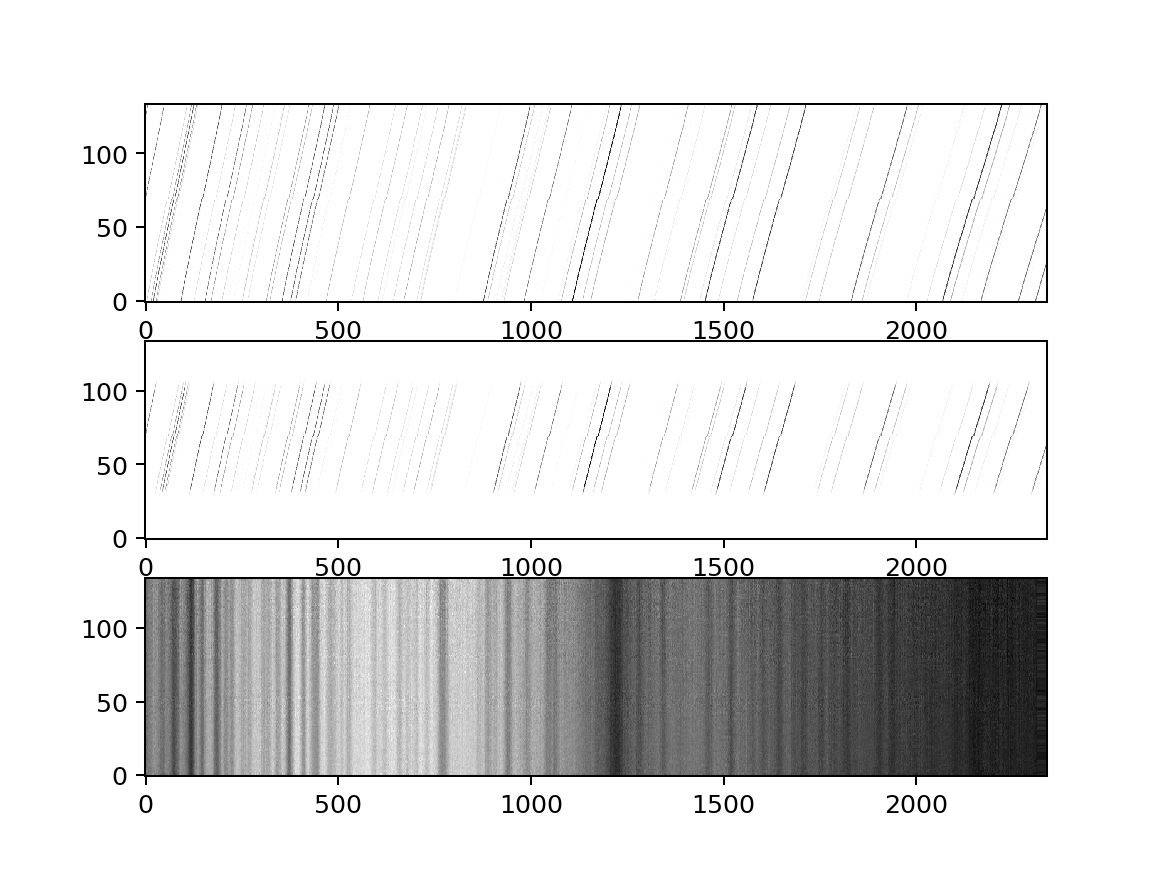

In [3]:
#create the shifted spectrum for signal injection

#compute planet velocity for each orbital phase
vp = Kp*np.sin(ph*2.*np.pi)

#create array of wavelengths and interpolate transmission spectrum to new grid
W = np.outer(1.-vp*1000./const.c.value,wl)
S = np.interp(W,wl_temp,template-1.) # *note that we subtract 1 here...

#we'll also scale the signal up so we can visualise it
scale_factor = 50
S *= scale_factor

#finally, we will weight the signal proportional to the trasnit
tweight = (1. - tmodel) / np.ptp(tmodel)
Sw = S * tweight[...,np.newaxis] + 1
# *then add it back here - this is to get the transit weighting right - think about why we do this...

#now we will do the injection by multiplying the signal to the real data
SI = Sw * spec

#make a plot of the arrays
f,a = plt.subplots(3)
a[0].imshow(S)
a[1].imshow(Sw)
a[2].imshow(SI)


So we're now left with a scenario where we have a planet's signal during transit which is Doppler shifted. One possibility is to remove the mean stellar spectrum from the data.

<IPython.core.display.Javascript object>


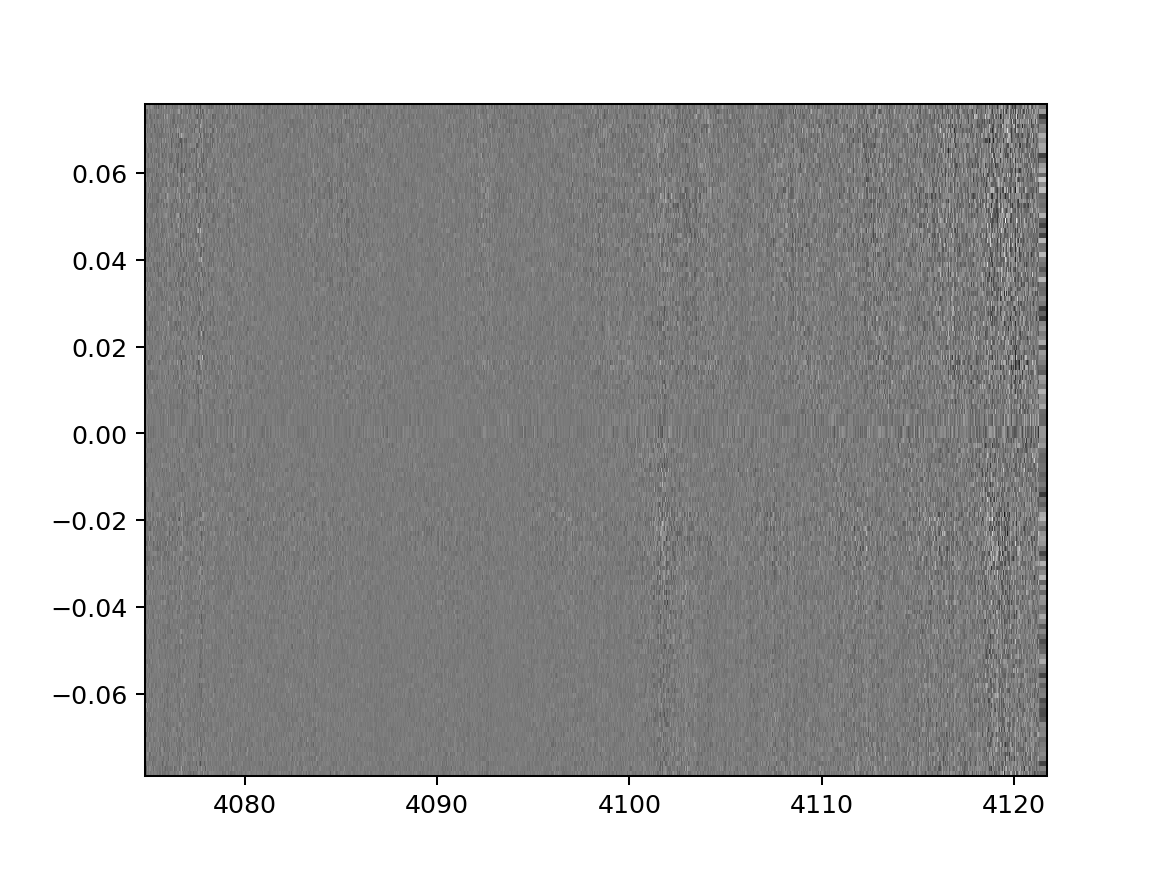

In [4]:

m = np.median(SI,axis=0)
Sn = SI/m #normalise the spectrum to remove stellar signal

f,a = plt.subplots(1)
a.pcolormesh(wl,ph,Sn)


Note that there is still some structure in the data - this is because dividing through by a mean spectrum does not remove all of the stellar and telluric signals, which have some time-dependance due to insturmental systematics, as well as the changing atmosphere.

Here we will use a slightly more complicated method machine learning technique called SysRem to remove the stellar/tellucic signals. Don't worry too much about the details, or any warning messages for now. You can see the Gibson et al. (2020) paper, or references within to learn more about it.

I've provided SysRem as a module, or python file, that just needs to be placed in the same directory as the notebook and then imported.

Essentially SysRem reconstructs a 2D array by decomposing it into 2 x 1D vectors (in this case time x wavelength). It does this by iteratively fitting for the best two (1D) vectors that can be multiplied together to reconstruct the data (using weighted least sqaures as the metric). Once the algorithm converges, this model is subtracted from the data, and the process is repeated again. This way we can build up a model of the data set by adding more and more components. We want to use enough components to accurately remove the stellar/telluric signal, while not too many so that we preserve the plaents signal (which is moving diagonally through the dataset and therefore not modelling out easily).


Performing sysrem for order 1
 sysrem converged after 11 iterations
 sysrem converged after 53 iterations
 sysrem converged after 35 iterations
 sysrem converged after 66 iterations
 sysrem didnt converge after 100 iterations
 sysrem converged after 53 iterations
 sysrem didnt converge after 100 iterations
 sysrem converged after 80 iterations
 sysrem didnt converge after 100 iterations
 sysrem didnt converge after 100 iterations
 sysrem didnt converge after 100 iterations
 sysrem didnt converge after 100 iterations
 sysrem didnt converge after 100 iterations
 sysrem didnt converge after 100 iterations
 sysrem didnt converge after 100 iterations


<IPython.core.display.Javascript object>


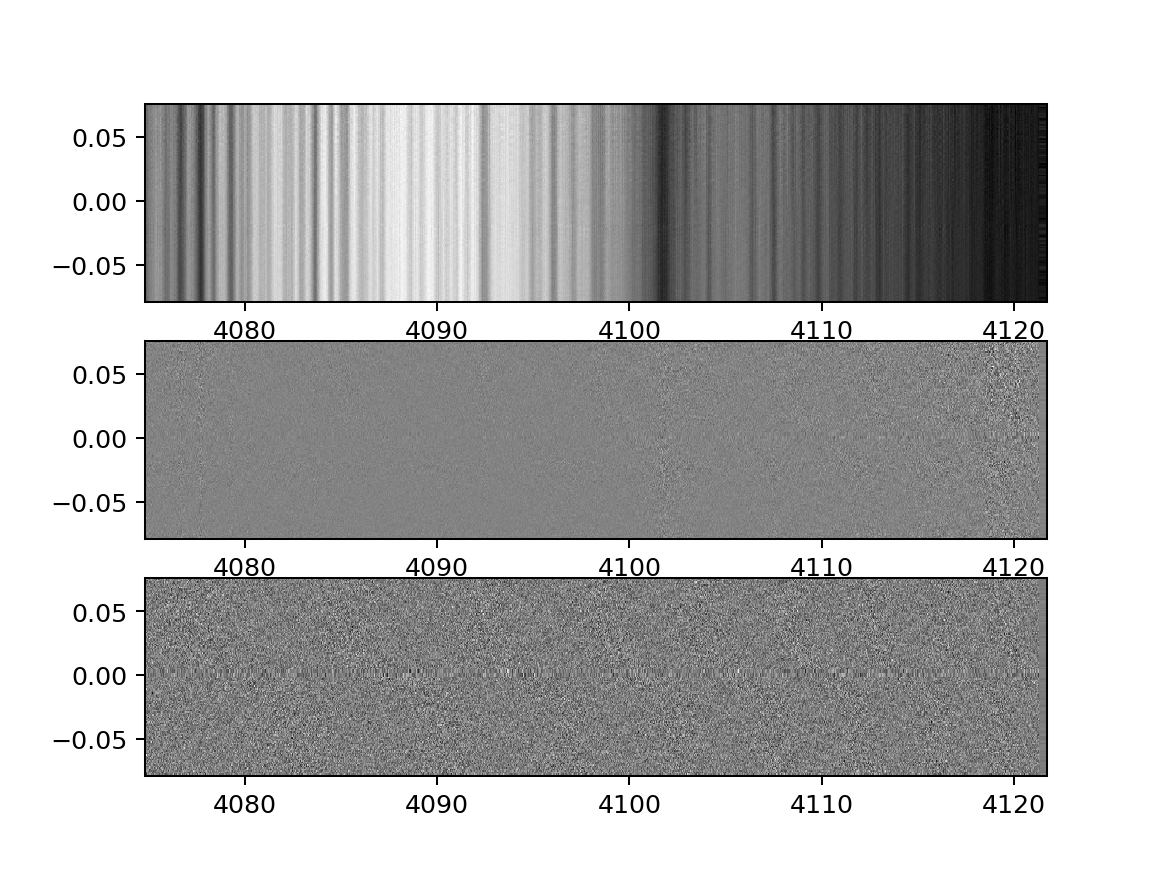

In [5]:
import SysRem

#use sysrem to contruct a model of the data
N_components = 15 #number of iterations of sysrem to use
Msys = SysRem.FastModelSysRem(SI,spec_err,N_components) #get model of data

#correct data using SysRem model
R = SI / np.abs(Msys) - 1.
Re = spec_err / Msys #do the same for the uncertainties

#we also need to be careful about clearing up nans/infs etc after division
R[np.isnan(R)] = 0.
R[np.isinf(R)] = 0.
Re[Re < 0] = np.inf
Re[np.isnan(Re)] = np.inf #reset errors to infs
Re[np.isclose(Re,0)] = np.inf #reset errors to infs


f,a = plt.subplots(3)
a[0].pcolormesh(wl,ph,Msys)
a[1].pcolormesh(wl,ph,R)
a[2].pcolormesh(wl,ph,R/Re)


Now we have the same setup as before, and we just need to cross-correlate with the models and sum over the velocity.

The one difference we will make, is to normlise the data by its *variance* before taking the CCF. This is important where the errors change with time and wavelength, which is generally the case.

### Explore further

- Try to recover the planetary signal, by cross-correlating the signal, then summing in velocity to create a $K_p-v_{sys}$ map
